# Lab 1: Properties of CCD Cameras

In [3]:
### for array operations
import numpy as np

### for plotting
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

### for operations on FITS images
from astropy.io import fits

### statistics functions needed in this tutorial
from scipy import stats
from scipy.stats import norm
from scipy.stats import mode
import scipy as sp

### for changing directory
import os

### for displaying images (not very good but better than nothing)
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.visualization import simple_norm

### for curve fitting
from scipy.optimize import curve_fit

### for auto-completing things in loops
import glob

# 4.1 Bias Frames
## 4.1.1

In [4]:
### Open bias file - May need to change to your directory
os.chdir('C:/Users/19294/Desktop/JUPYTER NOTEBOOKS/Lab 1/Imaging CCD')
hdulist = fits.open('bias0C.00000000.BIAS.FIT')

In [5]:
### Basic Info and Shape of image
hdulist.info()
imagedata = hdulist[0].data
print('Size:', imagedata.shape)

Filename: bias0C.00000000.BIAS.FIT
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   (1024, 1024)   int16 (rescales to uint16)   
Size: (1024, 1024)


C:\Users\19294\AppData\Local\Temp\ipykernel_21088\794211856.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


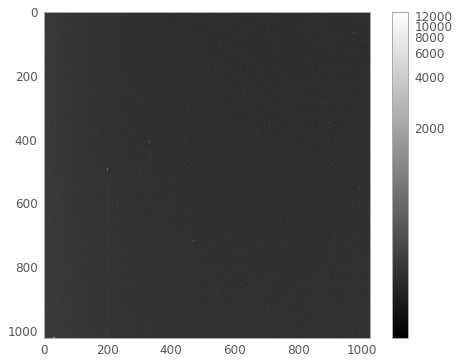

In [6]:
### Make a quick image (hard to see hot pixels, so open in ds9 for better look)
plt.figure()
plt.grid(False)
bias_norm=simple_norm(imagedata, 'log')
plt.imshow(imagedata, cmap='gray', norm=bias_norm) #bias_norm is a placeholder for if I find better function to display img
plt.colorbar()

In [7]:
### Find minmax values to see what we should set our x range to in the histogram
countvalues = imagedata.flatten()
print('Maximum:',np.max(countvalues))
print('Minimum:',np.min(countvalues))

Maximum: 13024
Minimum: 972


Text(0, 0.5, 'Frequency')

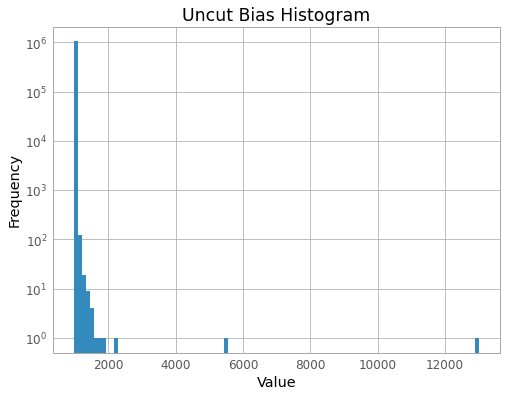

In [8]:
### Make the histogram
plt.hist(countvalues,bins=100);
plt.yscale('log')
plt.title('Uncut Bias Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

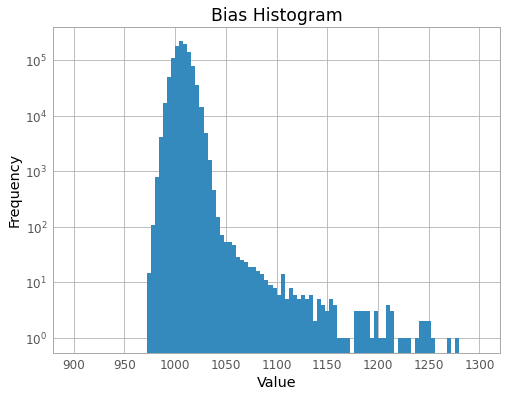

In [9]:
### Make our range nicer to see the distribution more clearly
plt.hist(countvalues,bins=100,range=[900,1300]);
plt.yscale('log')
plt.title('Bias Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

As we can see in the first histogram there's some crazy hot pixels. However even when we zoom into the main distribution in the second histogram there are some hot pixels beyond 1150. Let's set our **cut to 1125** for now, since we can see this is where gaps in the bars begin to start.

In [10]:
### Calculate proportion of hot pixels
originalsize = np.prod(countvalues.shape)
clippedvalues = countvalues[countvalues<1125]
clippedsize = np.prod(clippedvalues.shape)
print('Hot Pixel Proportion: ', 1-clippedsize/originalsize)

Hot Pixel Proportion:  9.72747802734375e-05


So hot pixels comprise 0.000097 or just under 0.01% of all pixels.

## 4.1.2

Range: 175
Average: 1006.7291346123579
Stdev: 7.817399627143881
Stat uncertainty: 0.00763499851380355


Text(0, 0.5, 'Frequency')

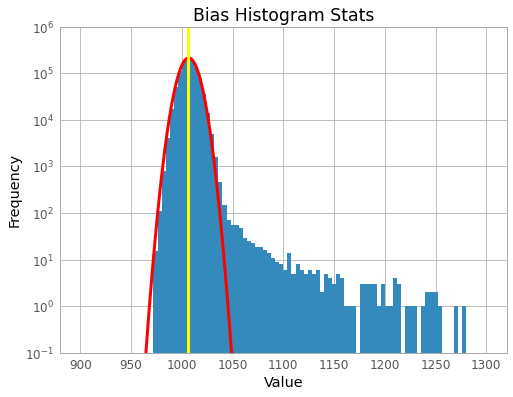

In [52]:
### Calculate some stats, clipping values
cmin=900
cmax=1300
nbins=100
normalization=(cmax-cmin)/nbins*len(countvalues[(countvalues>=cmin) & (countvalues<=cmax)])

clipmin=cmin
clipmax=1075
clippedvalues = countvalues[(countvalues>=clipmin) & (countvalues<=clipmax)]

mu=np.mean(clippedvalues)
sig=np.std(clippedvalues)
mode=stats.mode(clippedvalues)[0][0]

print("Range:",clipmax-clipmin) 
print("Average:",mu) 
print("Stdev:",sig) 

statuncertainty = sig / (np.prod(clippedvalues.shape))**(1/2)
print("Stat uncertainty:",statuncertainty)

### Plot these stats on graph
xarray=np.linspace(cmin,cmax,nbins*10)
yarray=normalization*norm.pdf(xarray,loc=mu, scale=sig)

plt.hist(countvalues,range=[cmin,cmax], bins=nbins);
plt.yscale('log')
plt.ylim([0.1,1e6])
plt.plot(xarray,yarray,color="red",linewidth=3.0)
plt.axvline(x=mode,linewidth=3.0,color="yellow")
plt.title('Bias Histogram Stats')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [12]:
### Find out the gain
header = hdulist[0].header
gain = header['EGAIN']
print('Gain:',gain)
print('Readout Noise:',sig*gain, 'e-')

Gain: 2.06
Readout Noise: 16.103843231916397 e-


Our measured read out noise from our experimental bias image is 16.1 e-

The manual says read out noise is 14.8 e-. So I would say our value is very close since often times the manual numbers are in optimal conditions--it's not surprising that we're 1 electron higher in noise.

# 4.2 Dark Frames
## 4.2.1

In [13]:
### Open all dark frames for 30 s exposure
hdudark0 = fits.open('dark0C30s.00000000.DARK.FIT')
hdudark1 = fits.open('dark0C30s.00000001.DARK.FIT')
hdudark2 = fits.open('dark0C30s.00000002.DARK.FIT')
hdudark3 = fits.open('dark0C30s.00000003.DARK.FIT')
hdudark4 = fits.open('dark0C30s.00000004.DARK.FIT')
hdudark5 = fits.open('dark0C30s.00000005.DARK.FIT')
hdudark6 = fits.open('dark0C30s.00000006.DARK.FIT')
hdudark7 = fits.open('dark0C30s.00000007.DARK.FIT')
hdudark8 = fits.open('dark0C30s.00000008.DARK.FIT')
hdudark9 = fits.open('dark0C30s.00000009.DARK.FIT')

imagedata0 = hdudark0[0].data
imagedata1 = hdudark1[0].data
imagedata2 = hdudark2[0].data
imagedata3 = hdudark3[0].data
imagedata4 = hdudark4[0].data
imagedata5 = hdudark5[0].data
imagedata6 = hdudark6[0].data
imagedata7 = hdudark7[0].data
imagedata8 = hdudark8[0].data
imagedata9 = hdudark9[0].data

### Make a median of all the darks
allimages=[imagedata0,imagedata1,imagedata2,imagedata3,imagedata4,imagedata5,imagedata6,imagedata7,imagedata8,imagedata9]
median = np.median(allimages, axis=0)

### Write out
masterdark = fits.PrimaryHDU(median)
masterdark.writeto('masterdark.fits', overwrite='overwrite')

C:\Users\19294\AppData\Local\Temp\ipykernel_21088\3817933528.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


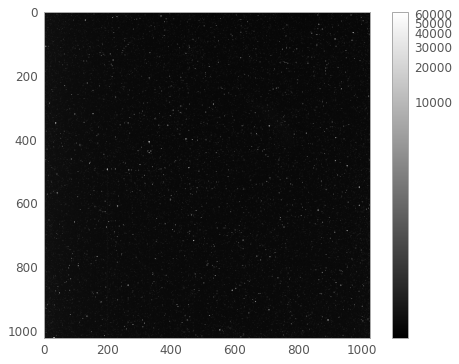

In [14]:
### Make a quick picture of the median
plt.figure()
plt.grid(False)
bias_norm=simple_norm(median, 'log')
plt.imshow(median, cmap='gray', norm=bias_norm)
plt.colorbar()

ds9 is better for finding the hot pixels but with a really quick log scale in the above image we can see the a few of the brightest hot pixels in the masterdark. Most of them should be hot in most of the images since we took the median (outliers are stripped). Any hot pixels that aren't in all the images might be due to cosmic rays.

## 4.2.2

Range: 400
Average: 1016.6821552485266
Stdev: 11.919693917776067
Stat uncertainty: 0.011645330353335455
Sys uncertainty: 0.1


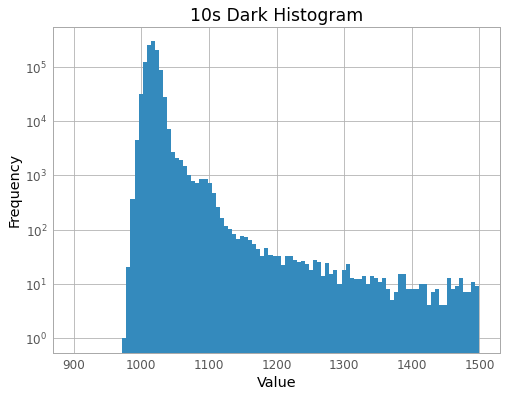

In [44]:
### Open time series darks
hdudarkVARY0 = fits.open('dark0C.00000000.DARK.FIT') # 10s
hdudarkVARY1 = fits.open('dark0C.00000001.DARK.FIT') # 15s
hdudarkVARY2 = fits.open('dark0C.00000002.DARK.FIT') # 25s
hdudarkVARY3 = fits.open('dark0C.00000003.DARK.FIT') # 40s
hdudarkVARY4 = fits.open('dark0C.00000004.DARK.FIT') # 60s
hdudarkVARY5 = fits.open('dark0C.00000005.DARK.FIT') # 90s
hdudarkVARY6 = fits.open('dark0C.00000006.DARK.FIT') # 120s

imagedataVARY0 = hdudarkVARY0[0].data
imagedataVARY1 = hdudarkVARY1[0].data
imagedataVARY2 = hdudarkVARY2[0].data
imagedataVARY3 = hdudarkVARY3[0].data
imagedataVARY4 = hdudarkVARY4[0].data
imagedataVARY5 = hdudarkVARY5[0].data
imagedataVARY6 = hdudarkVARY6[0].data

### Histogram and stats of 10s dark
countvaluesVARY0 = imagedataVARY0.flatten()

plt.hist(countvaluesVARY0,bins=100,range=[900,1500]);
plt.yscale('log')
plt.title('10s Dark Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

clipmaxV0=1300
clippedvaluesV0 = countvaluesVARY0[(countvaluesVARY0>=clipmin) & (countvaluesVARY0<=clipmaxV0)]

muV0=np.mean(clippedvaluesV0)
sigV0=np.std(clippedvaluesV0)
modeV0=stats.mode(clippedvaluesV0)[0][0]

print("Range:",clipmaxV0-clipmin)
print("Average:",muV0)
print("Stdev:",sigV0)

statuncertainty0 = sigV0 / (np.prod(clippedvaluesV0.shape))**(1/2)
print("Stat uncertainty:",statuncertainty0)

sysuncertainty = 0.1
print("Sys uncertainty:",sysuncertainty)

Range: 350
Average: 1020.9676655993262
Stdev: 13.446621474086788
Stat uncertainty: 0.013140398126775015
Sys uncertainty: 0.1


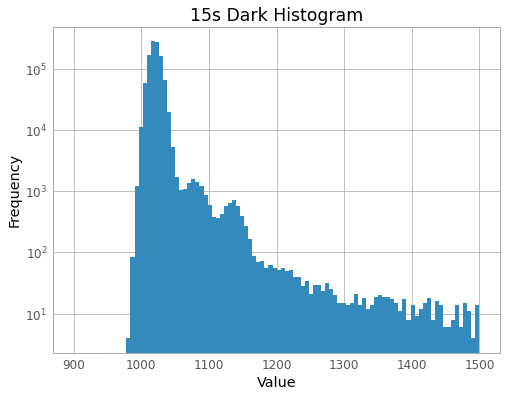

In [45]:
### Histogram and stats of 15s dark
countvaluesVARY1 = imagedataVARY1.flatten()

plt.hist(countvaluesVARY1,bins=100,range=[900,1500]);
plt.yscale('log')
plt.title('15s Dark Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

clipmaxV1=1250
clippedvaluesV1 = countvaluesVARY1[(countvaluesVARY1>=clipmin) & (countvaluesVARY1<=clipmaxV1)]

muV1=np.mean(clippedvaluesV1)
sigV1=np.std(clippedvaluesV1)
modeV1=stats.mode(clippedvaluesV1)[0][0]

print("Range:",clipmaxV1-clipmin)
print("Average:",muV1)
print("Stdev:",sigV1)

statuncertainty1 = sigV1 / (np.prod(clippedvaluesV1.shape))**(1/2)
print("Stat uncertainty:",statuncertainty1)

sysuncertainty = 0.1
print("Sys uncertainty:",sysuncertainty)

Range: 400
Average: 1029.9901402906703
Stdev: 18.102757064122724
Stat uncertainty: 0.01769444440424348
Sys uncertainty: 0.1


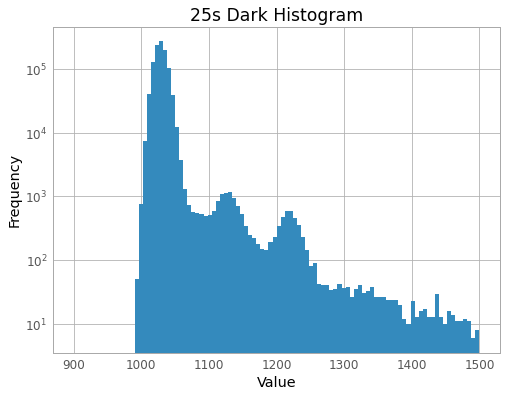

In [46]:
### Histogram and stats of 25s dark
countvaluesVARY2 = imagedataVARY2.flatten()

plt.hist(countvaluesVARY2,bins=100,range=[900,1500]);
plt.yscale('log')
plt.title('25s Dark Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

clipmaxV2=1300
clippedvaluesV2 = countvaluesVARY2[(countvaluesVARY2>=clipmin) & (countvaluesVARY2<=clipmaxV2)]

muV2=np.mean(clippedvaluesV2)
sigV2=np.std(clippedvaluesV2)
modeV2=stats.mode(clippedvaluesV2)[0][0]

print("Range:",clipmaxV2-clipmin)
print("Average:",muV2)
print("Stdev:",sigV2)

statuncertainty2 = sigV2 / (np.prod(clippedvaluesV2.shape))**(1/2)
print("Stat uncertainty:",statuncertainty2)

sysuncertainty = 0.1
print("Sys uncertainty:",sysuncertainty)

Range: 550
Average: 1042.7662504681755
Stdev: 26.527917582439596
Stat uncertainty: 0.025930415437322673
Sys uncertainty: 0.1


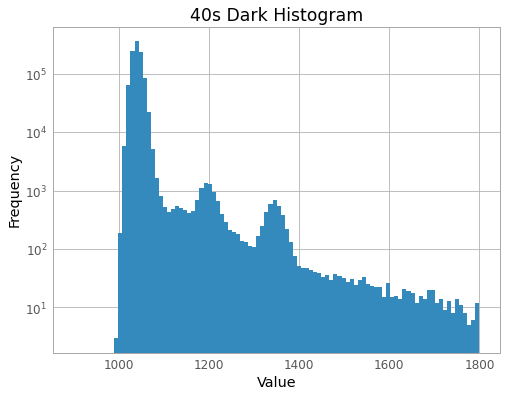

In [47]:
### Histogram and stats of 40s dark
countvaluesVARY3 = imagedataVARY3.flatten()

plt.hist(countvaluesVARY3,bins=100,range=[900,1800]);
plt.yscale('log')
plt.title('40s Dark Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

clipmaxV3=1450
clippedvaluesV3 = countvaluesVARY3[(countvaluesVARY3>=clipmin) & (countvaluesVARY3<=clipmaxV3)]

muV3=np.mean(clippedvaluesV3)
sigV3=np.std(clippedvaluesV3)
modeV3=stats.mode(clippedvaluesV3)[0][0]

print("Range:",clipmaxV3-clipmin)
print("Average:",muV3)
print("Stdev:",sigV3)

statuncertainty3 = sigV3 / (np.prod(clippedvaluesV3.shape))**(1/2)
print("Stat uncertainty:",statuncertainty3)

sysuncertainty = 0.1
print("Sys uncertainty:",sysuncertainty)

Range: 700
Average: 1060.3274048151252
Stdev: 37.5571170167699
Stat uncertainty: 0.03671479427907159
Sys uncertainty: 0.1


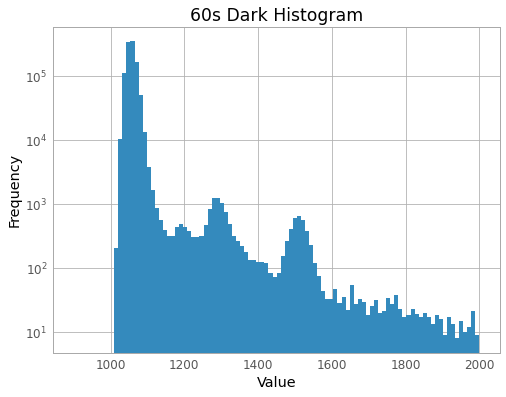

In [48]:
### Histogram and stats of 60s dark
countvaluesVARY4 = imagedataVARY4.flatten()

plt.hist(countvaluesVARY4,bins=100,range=[900,2000]);
plt.yscale('log')
plt.title('60s Dark Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

clipmaxV4=1600
clippedvaluesV4 = countvaluesVARY4[(countvaluesVARY4>=clipmin) & (countvaluesVARY4<=clipmaxV4)]

muV4=np.mean(clippedvaluesV4)
sigV4=np.std(clippedvaluesV4)
modeV4=stats.mode(clippedvaluesV4)[0][0]

print("Range:",clipmaxV4-clipmin)
print("Average:",muV4)
print("Stdev:",sigV4)

statuncertainty4 = sigV4 / (np.prod(clippedvaluesV4.shape))**(1/2)
print("Stat uncertainty:",statuncertainty4)

sysuncertainty = 0.1
print("Sys uncertainty:",sysuncertainty)

Range: 950
Average: 1085.6002018477866
Stdev: 54.73571341750148
Stat uncertainty: 0.053510107280516556
Sys uncertainty: 0.1


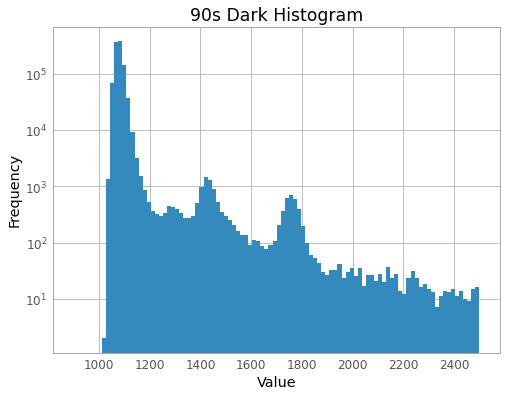

In [49]:
### Histogram and stats of 90s dark
countvaluesVARY5 = imagedataVARY5.flatten()

plt.hist(countvaluesVARY5,bins=100,range=[900,2500]);
plt.yscale('log')
plt.title('90s Dark Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

clipmaxV5=1850
clippedvaluesV5 = countvaluesVARY5[(countvaluesVARY5>=clipmin) & (countvaluesVARY5<=clipmaxV5)]

muV5=np.mean(clippedvaluesV5)
sigV5=np.std(clippedvaluesV5)
modeV5=stats.mode(clippedvaluesV5)[0][0]

print("Range:",clipmaxV5-clipmin)
print("Average:",muV5)
print("Stdev:",sigV5)

statuncertainty5 = sigV5 / (np.prod(clippedvaluesV5.shape))**(1/2)
print("Stat uncertainty:",statuncertainty5)

sysuncertainty = 0.1
print("Sys uncertainty:",sysuncertainty)

Range: 1350
Average: 1112.094888599895
Stdev: 73.82203223107447
Stat uncertainty: 0.07216181667336674
Sys uncertainty: 0.1


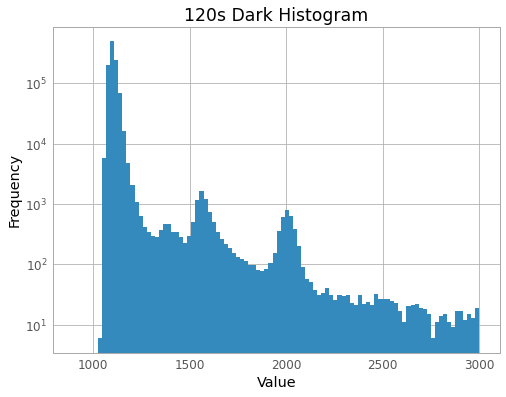

In [50]:
### Histogram and stats of 120s dark
countvaluesVARY6 = imagedataVARY6.flatten()

plt.hist(countvaluesVARY6,bins=100,range=[900,3000]);
plt.yscale('log')
plt.title('120s Dark Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

clipmaxV6=2250
clippedvaluesV6 = countvaluesVARY6[(countvaluesVARY6>=clipmin) & (countvaluesVARY6<=clipmaxV6)]

muV6=np.mean(clippedvaluesV6)
sigV6=np.std(clippedvaluesV6)
modeV6=stats.mode(clippedvaluesV6)[0][0]

print("Range:",clipmaxV6-clipmin)
print("Average:",muV6)
print("Stdev:",sigV6)

statuncertainty6 = sigV6 / (np.prod(clippedvaluesV6.shape))**(1/2)
print("Stat uncertainty:",statuncertainty6)

sysuncertainty = 0.1
print("Sys uncertainty:",sysuncertainty)

a = 1007 +/- 0
b = 0.892 +/- 0.000


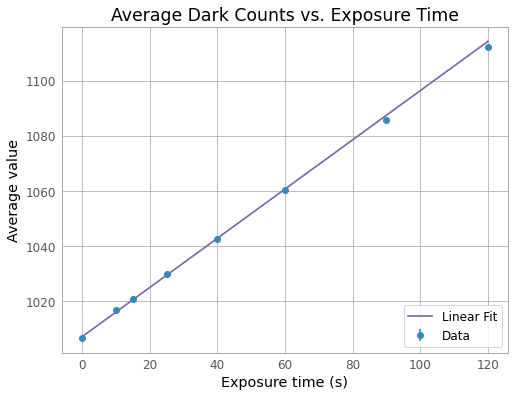

In [53]:
### Plot best fit linear

exptime= [0, 10,15,25,40,60,90,120]
mudata = [mu, muV0, muV1, muV2, muV3, muV4, muV5, muV6]
sigdata= [statuncertainty, statuncertainty0, statuncertainty1, statuncertainty2, statuncertainty3, statuncertainty4, statuncertainty5, statuncertainty6]

plt.errorbar(exptime, mudata, yerr=sigdata,fmt='o',)
plt.title('Average Dark Counts vs. Exposure Time')
plt.xlabel('Exposure time (s)')
plt.ylabel('Average value')

def func(x,a,b):
    return a+b*x

best_vals, covar = curve_fit(func, exptime, mudata, sigma=sigdata)

a = best_vals[0]
b = best_vals[1]

x = np.linspace(0, 120, num=100)
yfit = func(x,a,b)
plt.plot(x,yfit,label="fit")

plt.legend(["Linear Fit", "Data"], loc ="lower right")

print(f'a = {a:.0f} +/- {covar[0,0]:.0f}')
print(f'b = {b:.3f} +/- {covar[1,1]:.3f}')

In [25]:
### Determine the dark current from gain
print('Dark current:',b*gain, 'e-/p/s')

Dark current: 1.8374197360221842 e-/p/s


It would appear that the dark current is 1.84 e-/p/s. This is much lower than the 9 e-/p/s as described in the technical specifications. However, see the next section for 10 C:

Range: 300
Average: 1039.1447414357199
Stdev: 9.871356427972067
Stat uncertainty: 0.009640961965502393
Sys uncertainty: 0.1


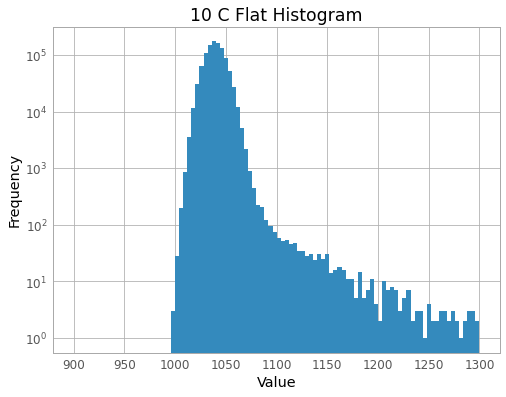

In [54]:
### Repeat for the 10 C Bias

hduhotflat = fits.open('bias10C.00000000.BIAS.FIT')
imagedatahotflat = hduhotflat[0].data
countvalueshotflat = imagedatahotflat.flatten()

plt.hist(countvalueshotflat,bins=100,range=[900,1300]);
plt.yscale('log')
plt.title('10 C Flat Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

clipmaxhotflat=1200
clippedvalueshotflat = countvalueshotflat[(countvalueshotflat>=clipmin) & (countvalueshotflat<=clipmaxhotflat)]

muhotflat=np.mean(clippedvalueshotflat)
sighotflat=np.std(clippedvalueshotflat)
modehotflat=stats.mode(clippedvalueshotflat)[0][0]

print("Range:",clipmaxhotflat-clipmin)
print("Average:",muhotflat)
print("Stdev:",sighotflat)

statuncertaintyhotflat = sighotflat / (np.prod(clippedvalueshotflat.shape))**(1/2)
print("Stat uncertainty:",statuncertaintyhotflat)

sysuncertainty = 0.1
print("Sys uncertainty:",sysuncertainty)

Range: 3100
Average: 1482.8069075718754
Stdev: 173.45222887850622
Stat uncertainty: 0.16956629377977522
Sys uncertainty: 0.1


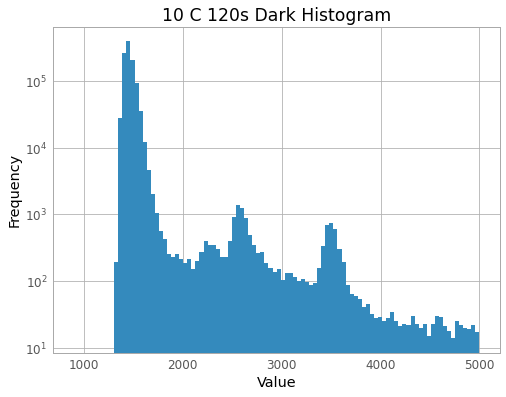

In [55]:
### Repeat for the 10 C 120 s exposure
hdudarkhot = fits.open('dark10C120s.00000000.DARK.FIT') # 10 c

imagedatahot = hdudarkhot[0].data

countvalueshot = imagedatahot.flatten()

plt.hist(countvalueshot,bins=100,range=[900,5000]);
plt.yscale('log')
plt.title('10 C 120s Dark Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

clipmaxhot=4000
clippedvalueshot = countvalueshot[(countvalueshot>=clipmin) & (countvalueshot<=clipmaxhot)]

muhot=np.mean(clippedvalueshot)
sighot=np.std(clippedvalueshot)
modehot=stats.mode(clippedvalueshot)[0][0]

print("Range:",clipmaxhot-clipmin)
print("Average:",muhot)
print("Stdev:",sighot)

statuncertaintyhot = sighot / (np.prod(clippedvalueshot.shape))**(1/2)
print("Stat uncertainty:",statuncertaintyhot)

sysuncertainty = 0.1
print("Sys uncertainty:",sysuncertainty)

In [36]:
print('Estimated Dark Current:',(muhot-muhotflat)/120*gain,'e-/p/s')

Estimated Dark Current: 7.61620051867067 e-/p/s


The dark current is a lot worse for 10C, as expected. 7.62 e-/p/s is much closer to the 9 e-/p/s in the specifications, but it is at 10C and not 0C as stated in the specifications. 

So basically, although our results disagree for the 0C 1.84 e-/p/s, I don't think it's too bad since by taking the darks at only 10C hotter than the specifications, we get similar results to the specifications.

# 4.3 Imaging Flat Fields
## 4.3.1

In [24]:
### Make the normalized flat
list_of_flats = sorted(glob.glob('C:/Users/19294/Desktop/JUPYTER NOTEBOOKS/Lab 1/Imaging CCD/flat.0000*.FIT'))
flatsdataA = [fits.open(filename)[0].data for filename in list_of_flats]

### Create a median of all flats, then divide that median by the mode of that median image to make norm flat.
medianflat = np.median(flatsdataA,axis=0)
medianflat_norm = medianflat/stats.mode(medianflat.flatten())[0][0]

### Write out
normflat = fits.PrimaryHDU(medianflat_norm)
normflat.writeto('normflat.fits', overwrite=True)

## 4.3.2
The center receives more counts than the edges, so it's more sensitive.  Also the "donuts" are dust particles.

Some dim regions get as low as 0.94 (namely the top left corner) while the brightest gets up to 1.05. So the dimmest regions would get 89% of the counts that the brightest regions get.

## 4.3.3
We will see that the stars at the edges of the image will be biased to have higher magnitude than those in the center. That is because the edges are less sensitive than the center. Here is a quick calculation:

Consider pixel (3,1021), which is located in the dimmest region of the image (top left corner). We choose 3,3 so it avoids the edge of the CCD. It has a value of 0.938 (typical for this area). For (512,512) central pixel, the value is 1.032. The pixel (551,386) is located in the brightest area of the image and has a value of 1.047.  Using the magnitude equation we calculate that:

Assuming baseline magnitude at 1.000 scaling,

- Top left will be 0.070 mag dimmer
- Center will be -0.034 mag brighter
- Brightest will be -0.050 mag brighter

Assuming the star starts in the center (512,512) as specified in the question,

- Top left will be 0.104 mag dimmer
- Brightest will be -0.016 mag brighter

## 4.3.4

Text(0, 0.5, 'Frequency')

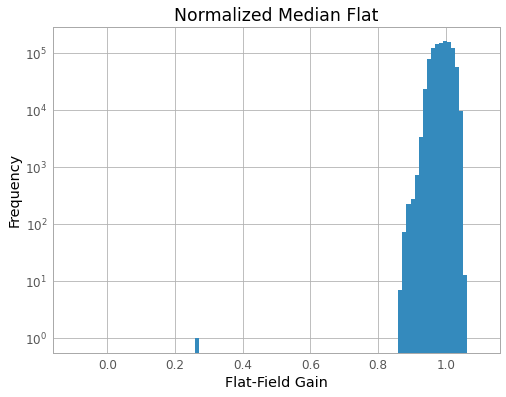

In [25]:
### Histogram of the normalized median flat.
normflat_cntvals=medianflat_norm.flatten()
plt.hist(normflat_cntvals,bins=100,range=[-0.1,1.1]); # Range has been checked, this includes all hot pixels
plt.yscale("log")
plt.title('Normalized Median Flat')
plt.xlabel('Flat-Field Gain')
plt.ylabel('Frequency')

We see exactly one dead pixel. It's not totally dead, but it recognizes far less photons.

## 4.3.5
If we forgot a flat field the night of, we won't be able to do it since we can't replicate the dust pattern on the CCD of that night very easily.

# 4.4 Spectrographic Calibration
## 4.4.1
The bottom slit is the 50 micron slit because it's the widest visually on ds9

## 4.4.2

In [26]:
### Open the spectroscopy flat
os.chdir('C:/Users/19294/Desktop/JUPYTER NOTEBOOKS/Lab 1/Spectroscopy CCD')

hduspecflat = fits.open('flat.00000000.FIT')

imagespecflat = hduspecflat[0].data

print(imagespecflat)

[[ 187  200  216 ...  169  158  214]
 [ 201  158  200 ...  247  209  226]
 [ 204  206  181 ...  193  215  210]
 ...
 [5005 4816 4734 ... 6571 6955 6796]
 [4834 4843 4745 ... 6554 6916 6700]
 [4690 4754 4777 ... 6783 6788 6707]]


Observe that the format is in [[row0] [row1] . . . [row255]].

Note that 0,0 correlates to the bottom left pixel. This can be verified in ds9 by looking at the bottommost row and starting left. You will observe this the pixel values are 187, 200, 216, ...

In [27]:
### Data manipulation
spliceimagespecflat = imagespecflat[23:83] # splice to 50 micron rows. Inspect the 3rd slit begins at row 24, ends at row 83 

transspliceimagespecflat = np.transpose(spliceimagespecflat) # transpose to get [[col0] [col1] ... [col765]]

medianarray = np.median(transspliceimagespecflat, axis = 1) #median all axis 1 arrays [med0 med1 ... med765]
### Feel free to print any of these steps to convince yourself this works

Text(0, 0.5, 'Value')

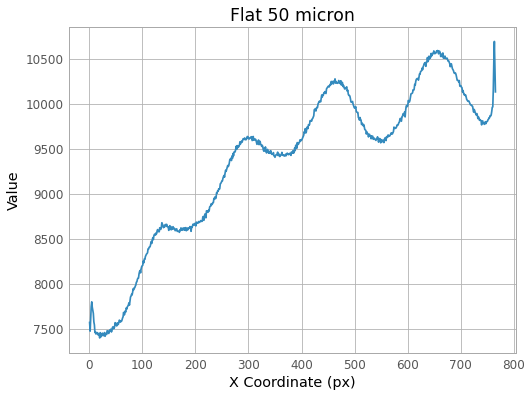

In [28]:
### Plot a histogram (median of each column of the 3rd slit)
specxvalues = np.arange(765)+1

plt.plot(specxvalues, medianarray)
plt.title('Flat 50 micron')
plt.xlabel('X Coordinate (px)')
plt.ylabel('Value')

## 4.4.3

[ 3.32421685e-06 -1.07292749e-02  9.98724089e+00  7.24372415e+03]


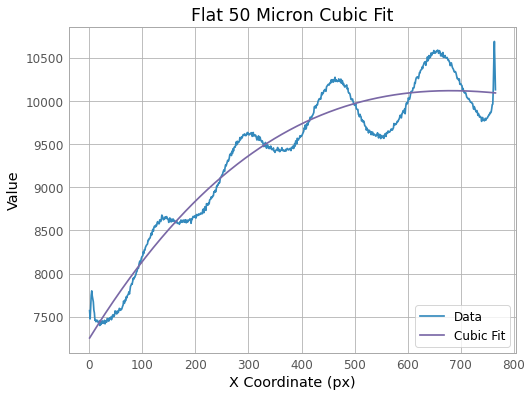

In [29]:
### Find a best fit with a cubic fit
polyfit = np.polyfit(np.arange(765)+1, medianarray, 3)
print(polyfit)

### Evaluate the function at integers from 0 to 765 for the plot
ypolyfit_list = [polyfit[0]*x**3 + polyfit[1]*x**2 + polyfit[2]*x + polyfit[3] for x in specxvalues]

### Plot both the data and the best fit
plt.plot(specxvalues,medianarray)
plt.plot(specxvalues,ypolyfit_list)
plt.title('Flat 50 Micron Cubic Fit')
plt.xlabel('X Coordinate (px)')
plt.ylabel('Value')
plt.legend(["Data", "Cubic Fit"], loc ="lower right")

Text(0, 0.5, 'Flat-Field Gain')

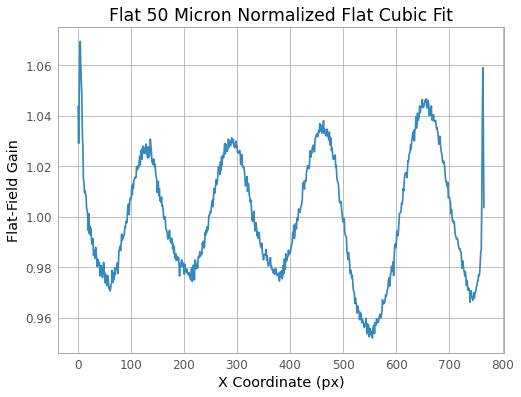

In [30]:
### Example of what 1D normalized median will look like (not needed for report)
norm_y_polyfit_list = np.divide(medianarray, ypolyfit_list)

plt.plot(specxvalues,norm_y_polyfit_list)
plt.title('Flat 50 Micron Normalized Flat Cubic Fit')
plt.xlabel('X Coordinate (px)')
plt.ylabel('Flat-Field Gain')

C:\Users\19294\AppData\Local\Temp\ipykernel_12272\4042599529.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


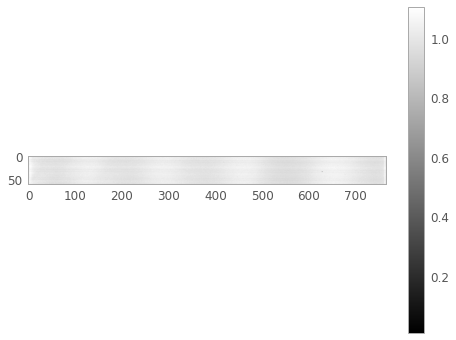

In [31]:
### Normalize our 2D Flat-field
norm_y_polyfit_list_2d = np.tile(ypolyfit_list, (60,1)) #[median row] -> [[med row][med row]...60x]

masterflat50 = spliceimagespecflat/norm_y_polyfit_list_2d #Divide 3rd slit science by array of median rows, dimensions agree

masterflat50micron = fits.PrimaryHDU(masterflat50)
masterflat50micron.writeto('masterflat50micron.fits', overwrite='overwrite')

plt.figure()
plt.grid(False)
plt.imshow(masterflat50, cmap='gray')
plt.colorbar()
plt.autoscale()

The masterflat removes the gradient from dim to brighter left to right (spectrum) and leaves the wiggles (spectrograph response). Also there are row-to-row sensitivity differences that are more apparent.

## 4.4.4

C:\Users\19294\AppData\Local\Temp\ipykernel_12272\1308329526.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


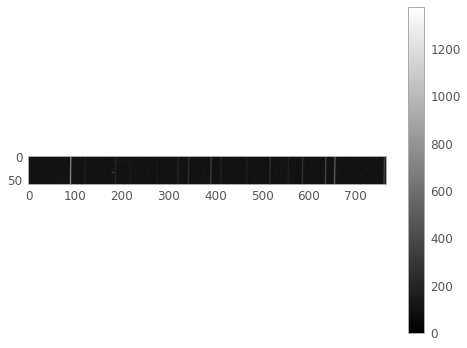

In [32]:
### Calibrate our science images
hduspec0 = fits.open('spec.00000000.FIT')

imagespec0 = hduspec0[0].data

spliceimagespec0 = imagespec0[23:83] #Splice the science image as necessary

calibsci0 = spliceimagespec0/masterflat50 # Divide by our masterflat50

calibscience0_50micron = fits.PrimaryHDU(calibsci0)
calibscience0_50micron.writeto('calibscience50micron_0.fits', overwrite='overwrite')

plt.figure()
plt.grid(False)
plt.imshow(calibsci0, cmap='gray')
plt.colorbar()
plt.autoscale()

## 4.4.5

[9.75432188e-01 5.76161990e+03]


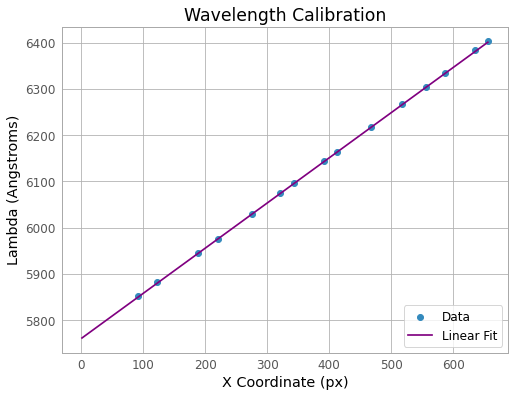

In [33]:
### Derive the wavelength calibration

### x-coordinates from visual inspection; lambda coordinates from https://physics.nist.gov/PhysRefData/Handbook/Tables/neontable2.htm
xcoordarray = [92, 122.5, 187.5, 220, 276, 321, 343, 391.5, 413, 467.5, 518, 557, 587, 636, 656]
lambdaarray = [5852.48, 5881.89, 5944.83, 5975.53, 6029.99, 6074.34, 6096.16, 6143.06, 6163.59, 6217.28, 6266.49, 6304.79, 6334.43, 6382.99, 6402.25]

### Linear fit
calib_polyfit = np.polyfit(xcoordarray, lambdaarray, 1)
print(calib_polyfit)

### Plot the emission lines and fit
plt.scatter(xcoordarray,lambdaarray)
plt.plot(np.arange(656)+1,[calib_polyfit[0]*x + calib_polyfit[1] for x in range(0,656)], c = "purple")
plt.title('Wavelength Calibration')
plt.xlabel('X Coordinate (px)')
plt.ylabel('Lambda (Angstroms)')
plt.legend(["Data", "Linear Fit"], loc ="lower right")

It appears that each pixel corresponds to 0.975 Angstroms, with pixel 1 corresponding to 5761.62 Angstroms, increasing right

## 4.4.6

Text(0, 0.5, 'Value')

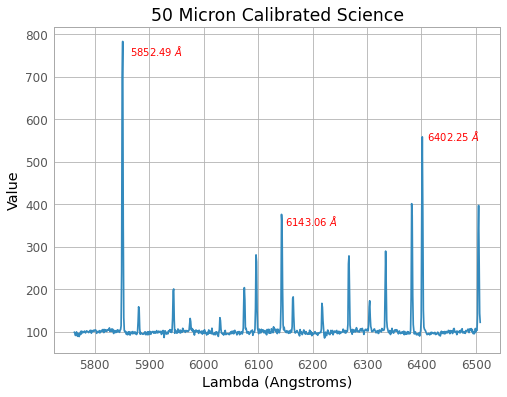

In [36]:
### Plot the counts as a function of wavelength
transcalibsci0 = np.transpose(calibsci0) #transpose to get [[col0] [col1] ... [col59]]

medianarraysci0 = np.median(transcalibsci0, axis = 1) #median all columns to get [med0 med1 ... med59]

plt.text(5865, 750, '5852.49 $\AA$', fontsize=10, c = 'red')
plt.text(6150, 350, '6143.06 $\AA$', fontsize=10, c = 'red')
plt.text(6410, 550, '6402.25 $\AA$', fontsize=10, c = 'red')
plt.plot(specxvalues*calib_polyfit[0]+calib_polyfit[1], medianarraysci0) # x axis is corrected for dispersion
plt.title('50 Micron Calibrated Science')
plt.xlabel('Lambda (Angstroms)')
plt.ylabel('Value')

## 4.4.7

In [35]:
### Determine spectrograph length and dispersion
print("Spectrograph length: ", calib_polyfit[0]*765, 'Angstroms') 
print("Spectrograph dispersion: ", calib_polyfit[0], 'Angstroms')

Spectrograph length:  746.20562373779 Angstroms
Spectrograph dispersion:  0.9754321878925359 Angstroms


## 4.5 Calibration strategies (Henry)

There are 3 types of calibration exposures: bias frames, dark fields, and flat fields.

The bias frame shows the readout noise of each pixel. It is already accounted for in a dark frame. 

Dark frames is taken over the same time interval as each science exposure but without light exposure, and shows the dark current of each pixel. The dark frames are combined into a median master dark frame that is then subtracted from the science images to remove dark current and bias current. 

Flat fields are taken over the same time interval as each science exposure but exposed to a uniform light source. They show the relative light sensitivities of different pixels. Flat fields reveal that pixels have varying sensitivities based on placement (e.g. pixels in the center of the image being more sensitive than pixels on the boundaries) and dust particles on the CCD sensor. The science image, after subtracting the master dark, is then divided by the flat field to compensate for the differing pixel sensitivities.

All calibration exposures have to be taken with the same telescope and instrument setup as the observations. Focus also doesn't matter very much because the change is so minor when looking at stars practically at infinity. The bias frames and dark fields can be taken the next day as needed, as they involve no light exposure and hence are not dependent on current local lighting conditions. However, the flat field needs to be taken on the same day with the same observation setup, since it varies strongly based on the placement of dust particles on the CCD sensor. It is theoretically possible but exceedingly unlikely to have the same dust placement on the CCD sensor between 2 different observing days.